## Assignment 4 
#### -- Pattern Recognition
#### -- João Pedro Moreto Lourenção

1. Geração do conjunto de dados

In [9]:
import numpy as np
import pandas as pd

a = 6
mean1 = np.array([0,0,0])
matriz_cov_1 = np.array([[0.5, 0, 0],
                        [0, 0.5, 0],
                        [0, 0, 0.01]])

matriz_cov_2 = np.array([[1, 0, 0],
                        [0, 1, 0],
                        [0, 0, 0.01]])

means2 = np.array([
    [a, 0, 0],
    [a/2, a/2, 0],
    [0, a, 0],
    [-a/2, -a/2, 0],
    [-a, 0, 0],
    [-a/2, -a/2, 0],
    [0, -a, 0],
    [a/2, -a/2, 0]
])

data_class1 = np.random.multivariate_normal(mean1, matriz_cov_1, 100)

data_class2=[]

for mean in means2:
    data_class2.append(np.random.multivariate_normal(mean, matriz_cov_2, 100))

data_class2 = np.vstack(data_class2)

In [10]:
#label creation
# class 0 -> first 100 with mean1 and matriz_cov_1
# class 1 -> remaining with mean2 and matriz_cov_2

data = np.vstack([data_class1, data_class2])
labels = np.hstack([np.zeros(100), np.ones(800)])

In [11]:
# shuffling data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

1.a - Plotandos os dados para visualização

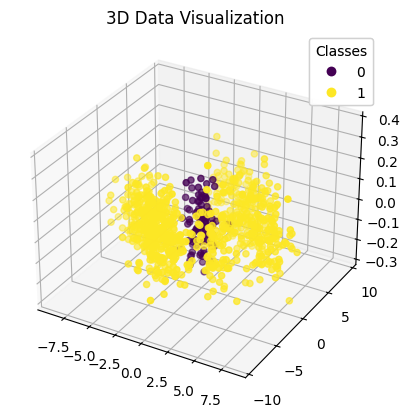

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap='viridis', marker='o')
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)
plt.title('3D Data Visualization')
plt.show()

1.b - Aplicando LDA nos dados

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=1)
lda_data = lda.fit_transform(data, labels)

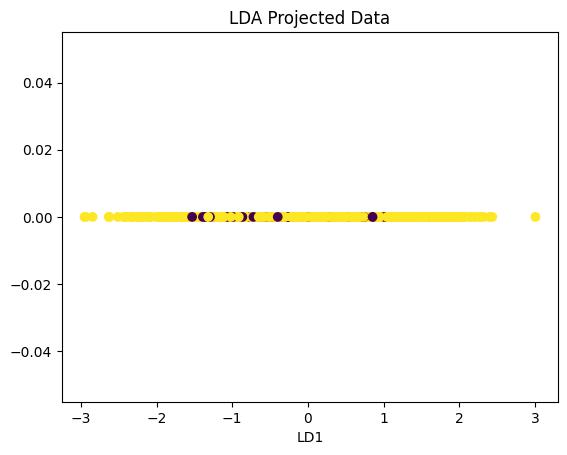

In [14]:
plt.figure()
plt.scatter(lda_data, np.zeros_like(lda_data), c=labels, cmap='viridis', marker='o')
plt.title('LDA Projected Data')
plt.xlabel('LD1')
plt.show()

As we have 2 only two classes, the result of LDA is a line that maximizes the separation between the classes.

Projecting data in the subspace

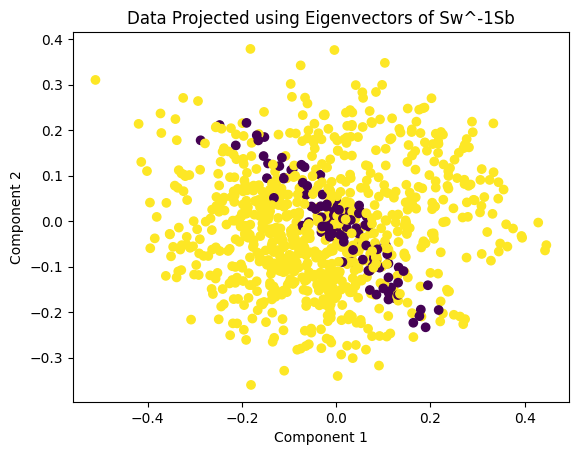

In [15]:
mean_total = np.mean(data, axis=0)
Sw, Sb = np.zeros((3,3)), np.zeros((3,3))

# calculating the dispersion matrix Sw and Sb
for c in [0,1]:
    if c == 0:
        data_c = data[labels==0]
    else:
        data_c = data[labels==1]

    mean_c = np.mean(data_c, axis=0)
    Sw += np.cov(data_c, rowvar=False) * data_c.shape[0]
    n_c = data_c.shape[0]
    mean_diff = (mean_c - mean_total).reshape(3,1)
    Sb += n_c * mean_diff.dot(mean_diff.T)

#calculating the eigenvalues and eigenvectors of Sw^-1Sb
eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))

# Ordering the eigenvalues and eigenvectors
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Projecting data at the corresponding eigenvectors into the biggest eigenvalues (non-negatives) 
non_negative_eigenvalues = eigenvalues[eigenvalues > 0]
W = eigenvectors[:, :len(non_negative_eigenvalues)] 
projected_data = data.dot(W)

plt.figure()
plt.scatter(projected_data[:, 0], projected_data[:, 1], c=labels, cmap='viridis', marker='o')
plt.title('Data Projected using Eigenvectors of Sw^-1Sb')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

Commenting the results:

- Sw: captures the variability inside of each class
- Sb: captures the variability between the classes
- Eigenvalues and Eigenvectros: $S_w^{-1}Sb$ eigenvalues indicates the importance of the directions (eigenvectors) for the classes separation. Non-negative eigenvalues indicate the directions in feature space where the separation between the classes is greatest.  
- Data Projection: the data were projected into the subspace defined by the eigenvectors corresponding to the largest (non-negative) eigenvalues.

The process performed is the essence of LDA: projecting the data into a subspace where the separation between classes is maximized, using the eigenvectors corresponding to the largest eigenvalues of $S_w^{-1}Sb$.

---

2. Generating the three-dimensional Archimedes spiral

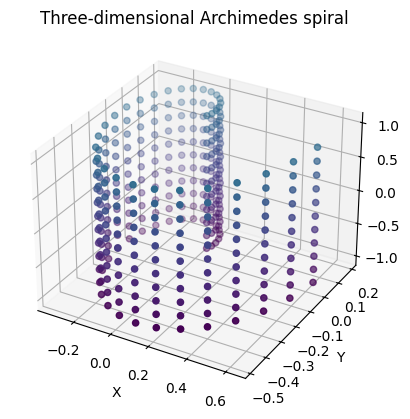

In [29]:
from mpl_toolkits.mplot3d import Axes3D

a = 0.1
theta_init = 0.5
theta_fin = 2.05 * np.pi
theta_step = 0.2
z_values = np.linspace(-1,1,11)

theta_values = np.arange(theta_init, theta_fin, theta_step)

x_points = []
y_points = []
z_points = []

for z in z_values:
    for theta in theta_values:
        r = a*theta
        x=r*np.cos(theta)
        y=r*np.sin(theta)
        x_points.append(x)
        y_points.append(y)
        z_points.append(z)

X = np.column_stack((x_points, y_points, z_points))

fig = plt.figure()
#ax = Axes3D(fig)
ax = fig.add_subplot(111, projection='3d')

num_points_per_spiral = len(theta_values)

colors = plt.cm.viridis(np.linspace(0, 1, num_points_per_spiral))

for i in range(len(z_values)):
    ax.scatter(x_points[i*num_points_per_spiral:(i+1)*num_points_per_spiral],
               y_points[i*num_points_per_spiral:(i+1)*num_points_per_spiral],
               z_points[i*num_points_per_spiral:(i+1)*num_points_per_spiral], color=colors[i], marker='o')
    
ax.set_title('Three-dimensional Archimedes spiral')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

2.a - Applicating PCA kernel to a dimension m=2

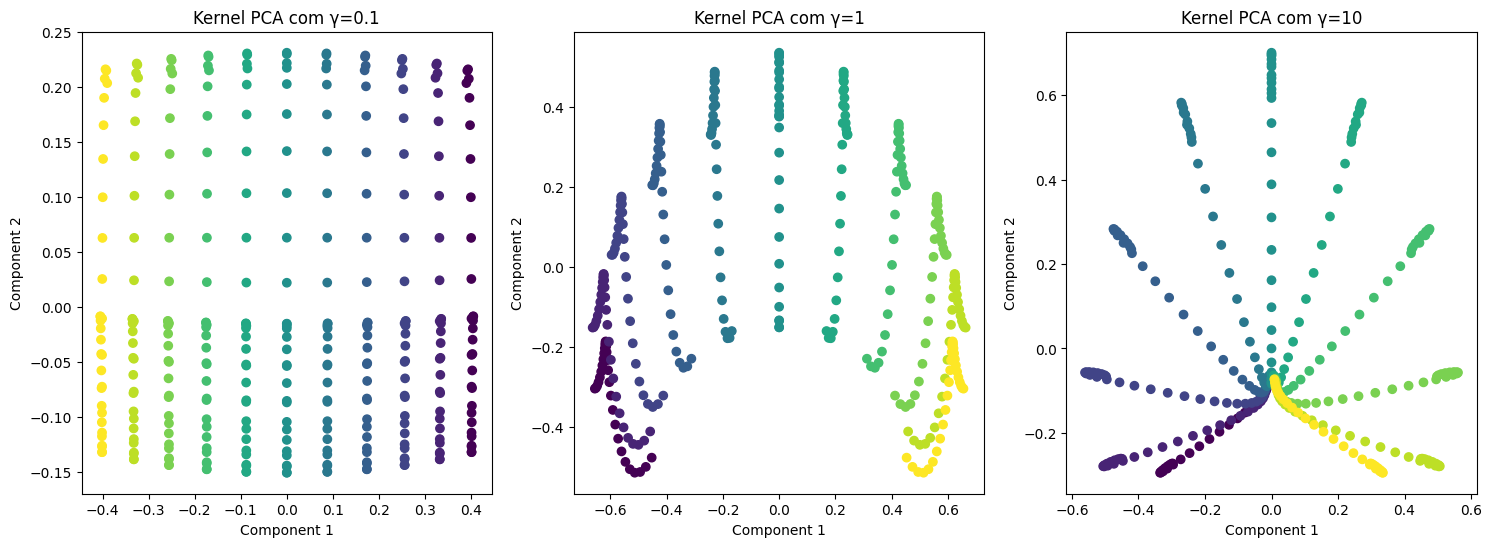

In [17]:
from sklearn.decomposition import KernelPCA

# Gaussian Kernel parameters
gammas = [0.1, 1, 10]

fig, axs = plt.subplots(1, len(gammas), figsize=(18,6))

for i, gamma in enumerate(gammas):
    kernel_PCA = KernelPCA(n_components=2, kernel='rbf', gamma=gamma)
    X_kernel_PCA = kernel_PCA.fit_transform(X)

    axs[i].scatter(X_kernel_PCA[:,0], X_kernel_PCA[:,1],c=z_points, cmap='viridis', marker='o')
    axs[i].set_title(f'Kernel PCA com γ={gamma}')
    axs[i].set_xlabel('Component 1')
    axs[i].set_ylabel('Component 2')

2.b - Repeating with PCA

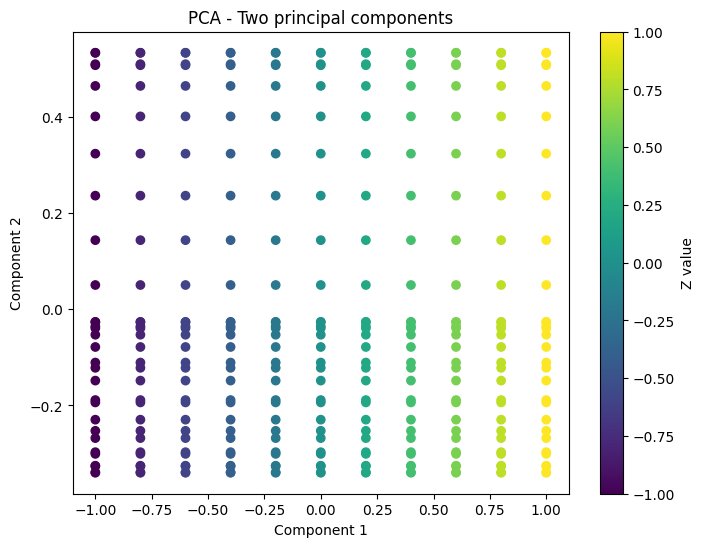

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=z_points, cmap='viridis', marker='o')
plt.title('PCA - Two principal components')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Z value')

plt.show()

2.c - Commenting and comparing methods

O Kernel PCA é muito útil para identificar relações não-lineares. Com o Kernel Gaussiano, é possível transformar os dados de um espaço de alta dimensionalidade, onde separar os dados e projetá-los novamente num espaço de baixa dimensionalidade é facilitado. Os valores de γ (gamma) alteram a forma que os dados são separados. Um valor baixo de γ resulta em uma transformação mais suave, mantendo mais da estrutura inicial dos dados. Um valor alto de γ enfatiza as características locais, fazendo com que a separação ocorra de maneira mais clara. 

O PCA projeta os dados ao longo das direções de maior variação, porém de maneira linear, ou seja, ignora relações não-lineares. No caso da espiral de Arquimedes utilizada, ele tende a capturar as duas direções de maior variação dos dados, pois a espiral possui 3 dimensões, então o PCA comprime a dimensão Z (profundidade).  